# Importing things

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import collections as cll
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Reading the data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ans = pd.DataFrame()

In [3]:
# Verificar se os dados de teste estão nos dados de treinamento
# Check if the test data is in the training data
print(set(test.columns).issubset(set(train.columns)))

True


## Quick data exploration

In [4]:
# What attributes do we have? What type are they?
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4829 entries, 0 to 4828
Data columns (total 55 columns):
ID                                    4829 non-null object
height_cm                             4829 non-null float64
weight_kg                             4829 non-null float64
eur_wage                              4829 non-null float64
skill_moves                           4829 non-null int64
weak_foot                             4829 non-null int64
crossing                              4829 non-null int64
finishing                             4829 non-null int64
heading_accuracy                      4829 non-null int64
short_passing                         4829 non-null int64
volleys                               4829 non-null int64
dribbling                             4829 non-null int64
curve                                 4829 non-null int64
free_kick_accuracy                    4829 non-null int64
long_passing                          4829 non-null int64
ball_control    

In [5]:
# Statisticaly describing the data
train.describe()

,height_cm,weight_kg,eur_wage,skill_moves,weak_foot,crossing,finishing,heading_accuracy,short_passing,volleys,...,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle
count,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,...,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000,4829.000000
mean,183.109961,76.990267,10016.359495,2.083868,2.819217,41.739283,39.410644,50.172292,52.684407,37.804307,...,66.328847,40.354111,52.861876,42.873887,42.798716,47.659350,44.654380,54.402568,40.929178,43.800373
std,6.690962,7.292228,21720.982928,0.726900,0.628180,19.045680,20.721807,20.877075,16.181135,18.377069,...,13.099721,19.790496,19.088383,21.958820,21.213381,14.071487,17.119506,14.146100,23.301924,23.571392
min,156.000000,49.000000,0.000000,1.000000,1.000000,6.000000,3.000000,4.000000,10.000000,4.000000,...,20.000000,3.000000,11.000000,4.000000,2.000000,10.000000,5.000000,5.000000,4.000000,7.000000
25%,178.000000,72.000000,1000.000000,2.000000,2.000000,27.000000,21.000000,40.000000,42.000000,23.000000,...,58.000000,22.000000,36.000000,22.000000,25.000000,37.000000,33.000000,46.000000,18.000000,19.000000
50%,184.000000,77.000000,3000.000000,2.000000,3.000000,43.000000,38.000000,55.000000,57.000000,37.000000,...,67.000000,42.000000,56.000000,45.000000,47.000000,48.000000,45.000000,56.000000,42.000000,46.000000
75%,188.000000,82.000000,9000.000000,3.000000,3.000000,58.000000,58.000000,66.000000,65.000000,52.000000,...,76.000000,57.000000,68.000000,63.000000,60.000000,58.000000,58.000000,65.000000,63.000000,66.000000
max,203.000000,107.000000,510000.000000,5.000000,5.000000,90.000000,94.000000,94.000000,88.000000,88.000000,...,96.000000,90.000000,94.000000,90.000000,92.000000,86.000000,90.000000,91.000000,90.000000,92.000000


In [6]:
# Checking the data size
print(train.shape)
print(test.shape)

(4829, 55)
(4829, 54)


In [7]:
# Finding out how many classes exists
train['preferred_pos'].nunique()

15

In [8]:
# Spliting train and test sets
ans['ID'] = test['ID']
X_train = train.drop(['preferred_pos', 'ID'], axis = 1)
y_train = train['preferred_pos']
X_test = test.drop(['ID'], axis = 1)

In [9]:
# Check for nulls
count_nan_train = len(X_train) - X_train.count()
count_nan_test = len(X_test) - X_test.count()
print(count_nan_train.sum())
print(count_nan_test.sum())

0
0


Counter({'prefers_gk': 965,
         'prefers_cm': 398,
         'prefers_st': 929,
         'prefers_cb': 1117,
         'prefers_rb': 318,
         'prefers_lb': 342,
         'prefers_cdm': 213,
         'prefers_cam': 157,
         'prefers_rw': 53,
         'prefers_lm': 124,
         'prefers_rm': 158,
         'prefers_lw': 37,
         'prefers_lwb': 4,
         'prefers_cf': 12,
         'prefers_rwb': 2})

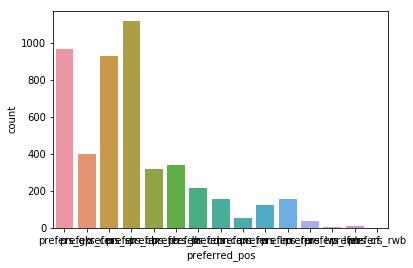

In [10]:
# Checking dataset balance
sns.countplot(y_train)
cll.Counter(y_train)

In [11]:
# Where the posision quantity is too low, change the label to a more commum position (to increase accuracy)
for i in range(len(y_train)):
    if y_train[i] == 'prefers_rwb' or y_train[i] == 'prefers_lwb' or y_train[i] =='prefers_lw' or y_train[i] =='prefers_cf' or y_train[i] =='prefers_rw':
        y_train[i] = 'prefers_cb'

#### Bodyshape Analysis

In [12]:
print(X_train['body_type'].unique())
print(X_test['body_type'].unique())

['Stocky' 'Normal' 'Lean' 'Courtois']
['Normal' 'Stocky' 'Lean' 'Akinfenwa' 'Neymar']


In [13]:
# Changing strange body types
for i in range(len(X_train)):
    if X_train['body_type'][i] == 'Courtois':
        X_train['body_type'][i] = 'Lean'
        
for i in range(len(X_test)):
    if X_test['body_type'][i] == 'Akinfenwa':
        X_test['body_type'][i] = 'Stocky' 
    if X_test['body_type'][i] == 'Neymar':
        X_test['body_type'][i] = 'Lean'

#### Dummy variables

In [14]:
body_shape = pd.get_dummies(X_train['body_type'])
X_train = pd.concat([X_train, body_shape], axis = 1).drop(['body_type'], axis = 1)

In [15]:
X_train.drop(['nationality'], axis = 1, inplace = True)

In [16]:
preferred_foot = pd.get_dummies(X_train['preferred_foot'])
X_train = pd.concat([X_train, preferred_foot], axis = 1).drop(['preferred_foot'], axis = 1)

#### Correlation

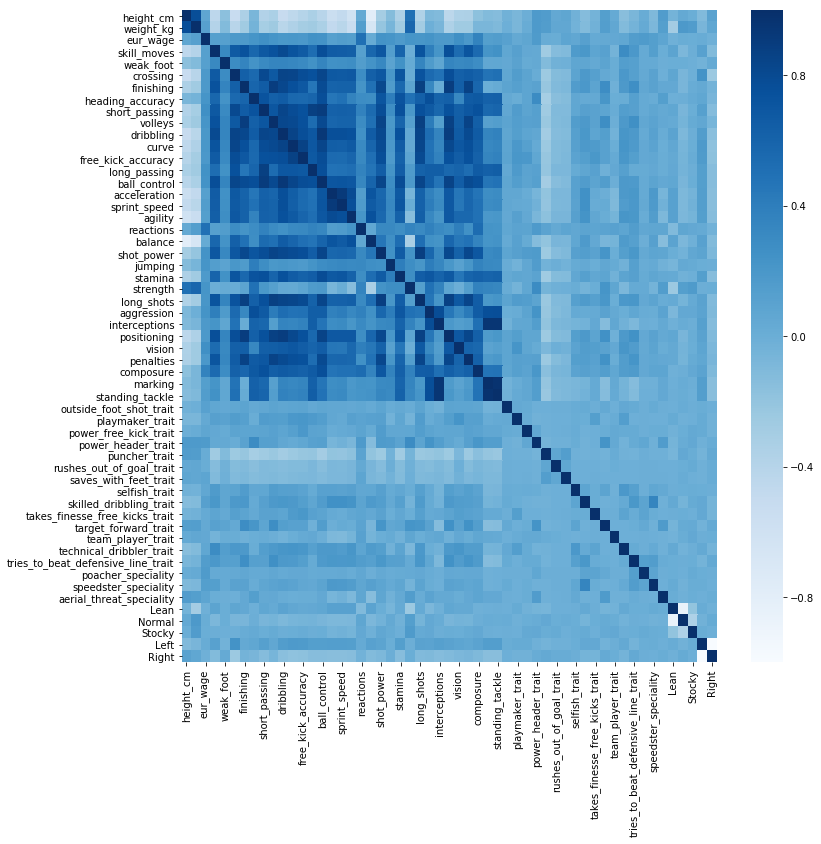

In [17]:
# Correlation between the attributes
plt.figure(figsize=(12,12))
sns.heatmap(X_train.corr(),cmap='Blues')

### Scaling attributes

In [18]:
features = X_train.columns
Scaler = preprocessing.StandardScaler()
X_train = Scaler.fit_transform(X_train)

# Models

In [19]:
# Using k_folds to evaluate
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
scoring = 'accuracy'

### Random Forest

In [20]:
%%time
rfc = RandomForestClassifier(n_estimators=100)
score = cross_val_score(rfc, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(round(np.mean(score)*100, 2))

86.35
CPU times: user 6.46 s, sys: 7.39 ms, total: 6.47 s
Wall time: 6.35 s


## Naive Bayes

In [21]:
bnb = BernoulliNB()
score = cross_val_score(bnb, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(round(np.mean(score)*100, 2))

78.19


## Neural Network

In [22]:
%%time
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(25, 15, 5), random_state=1,early_stopping=True)
score = cross_val_score(mlp, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(round(np.mean(score)*100, 2))

84.1
CPU times: user 36.7 s, sys: 27.3 ms, total: 36.8 s
Wall time: 9.2 s


## XGBoost

In [23]:
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

xgb = XGBClassifier()

grid_search = GridSearchCV(xgb, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=k_fold, verbose=0)
score = cross_val_score(grid_search, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(round(np.mean(score)*100, 2))

87.31


In [24]:
best_xgb = grid_search.fit(X_train, y_train)
best_xgb.best_params_

{'max_depth': 4, 'n_estimators': 150}

## Feature importance

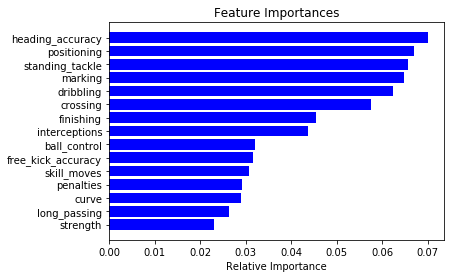

In [25]:
# Fit on the Random Forest to calculate the feature importance for each attribute
rfc.fit(X_train, y_train)
importances = rfc.feature_importances_
indices = np.argsort(importances)
# Print the top 15 feature ranking
quant = 15
plt.title('Feature Importances')
plt.barh(range(quant), importances[indices][-quant:], color='b', align='center')
plt.yticks(range(quant), [features[i] for i in indices[-quant:]])
plt.xlabel('Relative Importance')
plt.show()

# Making the submission

In [26]:
# Pre-processing the test data
body_shape = pd.get_dummies(X_test['body_type'])
X_test = pd.concat([X_test, body_shape], axis = 1).drop(['body_type'], axis = 1)

X_test.drop(['nationality'], axis = 1, inplace = True)

preferred_foot = pd.get_dummies(X_test['preferred_foot'])
X_test = pd.concat([X_test, preferred_foot], axis = 1).drop(['preferred_foot'], axis = 1)

X_test = Scaler.fit_transform(X_test)

In [27]:
# Making the prediction
prediction = best_xgb.predict(X_test)
ans['preferred_pos'] = prediction

ans.to_csv('answer.csv', index=False)